# 倒角距离变换(Chamfer Distance)

图像处理中的倒角距离变换(Chamfer Distance Transform)在对象匹配识别中经常用到，算法基本上是基于3x3的窗口来生成每个像素的距离值，分为两步完成距离变换，

第一步从左上角开始，从左向右、从上到下移动窗口扫描每个像素，检测在中心像素x的周围0、1、2、3四个像素，保存最小距离与位置作为结果，图示如下：

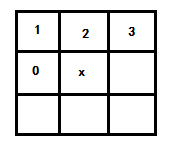

第二步从底向上、从右向左，对每个像素，检测相邻像素4、5、6、7保存最小距离与位置作为结果，如图示所：

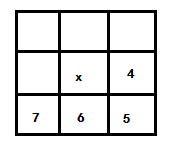

完成这两步以后，得到的结果输出即为倒角距离变换的结果。完整的图像倒角距离变

换代码实现可以分为如下几步：

1. 对像素数组进行初始化，所有背景颜色像素点初始距离为无穷大，前景像素点距离为0
2. 开始倒角距离变换中的第一步，并保存结果
3. 基于第一步结果完成倒角距离变换中的第二步
4. 根据距离变换结果显示所有不同灰度值，形成图像


In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import skimage.io
import imageio
from operator import itemgetter
from collections import defaultdict
from collections import Counter

In [2]:
src = imageio.imread('../datas/face4.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [54]:
'''
%   WEIGHTS = [1 sqrt(2)]   -> quasi-euclidean distance
%   WEIGHTS = [1 Inf]       -> "Manhattan" or "cityblock" distance
%   WEIGHTS = [1 1]         -> "Chessboard" distance
%   WEIGHTS = [3 4]         -> Borgerfors' weights
%   WEIGHTS = [5 7]         -> close approximation of sqrt(2)
%   WEIGHTS = [5 7 11]      -> Uses an additional weight for chess-knight
%                              shifts around each pixel( default)
'''
def chamfer_distance(src,weights=[5,7,11]):
    gray = src.astype(np.float32)
    if len(src.shape) > 2:
        gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY).astype(np.float32)
    w1 = weights[0]
    w2 = weights[1]
    
    if w2 < w1:
        w2 = 2 * w1
    # shifts in directions i and j for (1) forward and (2) backward iterations
    if len(weights) == 2:
        n_shifts = 4
        di1 = [-1, -1, -1,  0]
        dj1 = [-1,0,  1, -1]
        di2 = [1, 1, 1,  0]
        dj2 = [-1,  0,  1, 1]
        ws = [w2,w1,w2,w1]
    elif len(weights) == 3:
        n_shifts = 8
        w3 = weights[2]
        di1 = [-2, -2, -1, -1, -1, -1, -1,  0]
        dj1 = [-1, 1, -2, -1,  0,  1, 2, -1]
        di2 = [2, 2 ,1 ,1 ,1 ,1 ,1  ,0]
        dj2 = [-1, 1, 2, 1,  0, -1, -2, 1]
        ws =  [w3, w3, w3, w2, w1, w2, w3, w1]
    dst = np.ones_like(gray)
    dst.fill(np.finfo(np.float32).max)
    dst[~src] = 0
    D1,D2 = gray.shape
    
    for i in range(D1-2):
        for j in range(D2-2):
            if gray[i,j] == 0:
                continue
            new_val = dst[i,j]
            for k in range(n_shifts):
                i2 = i + di1[k]
                j2 = j + dj1[k]
                
                if (i2 < 0) or (i2 > D1) or (j2 < 0) or (j2 > D2):
                    continue
                if gray[i2,j2] == gray[i,j]:
                    new_val = min(new_val,dst[i2,j2] + ws[k])
                else:
                    new_val = min(new_val,ws[k])
            dst[i,j] = new_val
    print(D1,D2)
    for i in range(D1-3,0,-1):
        for j in range(D2-3,0,-1):
#             print(i,j)
            if gray[i,j] == 0:
                continue
            new_val = dst[i,j]
            for k in range(n_shifts):
                i2 = i + di2[k]
                j2 = j + dj2[k]
                if (i2 < 0) or (i2 > D1) or (j2 < 0) or (j2 > D2):
                    continue
#                 print(i2,j2)
                if gray[i2,j2] == gray[i,j]:
                    new_val = min(new_val,dst[i,j] + ws[k])
                else:
                    new_val = min(new_val,ws[k])
            dst[i,j] = new_val
#     dst[dst > 0] = dst[dst > 0] / w1
    dst = np.clip(dst,0,255)
    print(dst)
    return np.uint8(dst)

In [55]:
dst = chamfer_distance(gray)

375 750
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [ 15.  11.  11. ...  25. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]


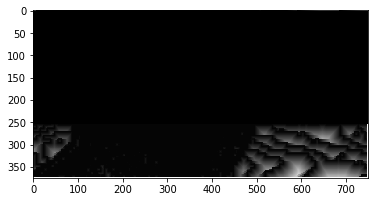

In [57]:
plt.imshow(dst,'gray')

In [51]:
def _index2coord(index):
    return np.array([index // neighborhood_size, index % neighborhood_size])

neighborhood_size = 5
_cache = {}

def chamfer_distance(a,b):
    x = _fast_assymetric_chamfer_distance(a,b)
    y = _fast_assymetric_chamfer_distance(b,a)
    return x + y

def _gen_paths():
    """
    Compute search order for each input pixel position.
    Search from closest to farthest, so that search can be stopped at
    success.
    """
    def path(i,j):
        return (max(abs(_index2coord(i)-_index2coord(j))), j)

    r = range(neighborhood_size**2)
    return [sorted([path(i,j) for j in r], key=itemgetter(0)) for i in r]

_paths = _gen_paths()

def _fast_assymetric_chamfer_distance(a,b):
    key = (tuple(a),tuple(b))

    if key in _cache:
        return _cache[key]

    set_a = set(a)
    result = 0
    for i,x in enumerate(b):
        if x not in set_a:
            result += 2 * neighborhood_size
        else:
            for dist,j in _paths[i]:
                if a[j] == x:
                    result += dist
                    break

    _cache[key] = result
    return result